In [ ]:
# !pyhon --version

In [ ]:
# !pip install opendatasets


In [1]:
import os

# Path to your kaggle.json file
file_path = "D:/Downloads/kaggle.json"

# Check if the file exists
if os.path.exists(file_path):
    print("kaggle.json found!")
    with open(file_path) as f:
        print("Content")
        preview: f.read(100)  # Read first 100 chars (safely)
else:
    print("kaggle.json not found. Check the path.")


kaggle.json found!
Content


In [ ]:
import os
import opendatasets as od

# Tell the system where to find kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = "D:/Downloads"

# Download the dataset
od.download(
    "https://www.kaggle.com/datasets/salader/dogs-vs-cats",
    data_dir=".",    # Current directory
    force=True       # Re-download if needed
)


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "D:/Desktop/CNN project/dogs-vs-cats/train"
test_dir = "D:/Desktop/CNN project/dogs-vs-cats/test"

# Normalize pixel values and split 20% for validation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# For final testing later (optional)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)


Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # binary output

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

# Save model
model.save("catvsdog_fixed.h5")
print("✅ Model saved successfully.")


In [5]:
import pickle  # ✅ Import this first!

# Save training history
with open("catvsdog_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("✅ Training history saved successfully.")


✅ Training history saved successfully.


 Model loaded.
 History loaded.


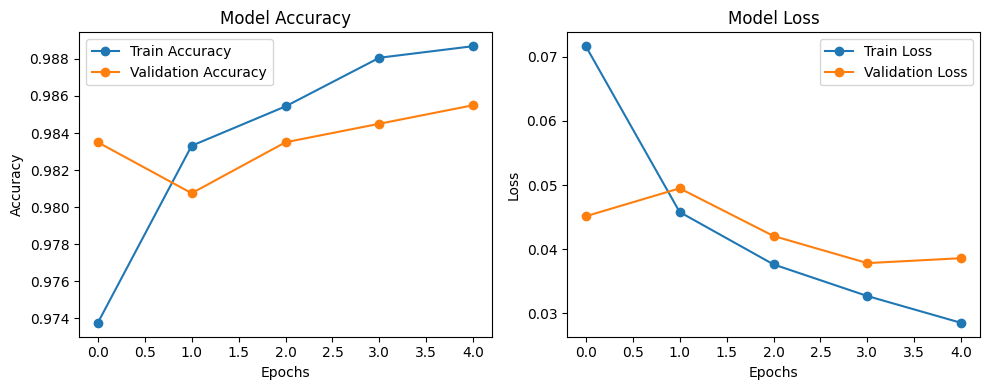

In [1]:
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# # Load model
model = load_model("catvsdog_fixed.h5")
print(" Model loaded.")

# Load training history
with open("catvsdog_history.pkl", "rb") as f:
    history_data = pickle.load(f)
print(" History loaded.")

# Plot accuracy & loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_data['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_data['loss'], label='Train Loss', marker='o')
plt.plot(history_data['val_loss'], label='Validation Loss', marker='o')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Cat (Confidence: 0.00)


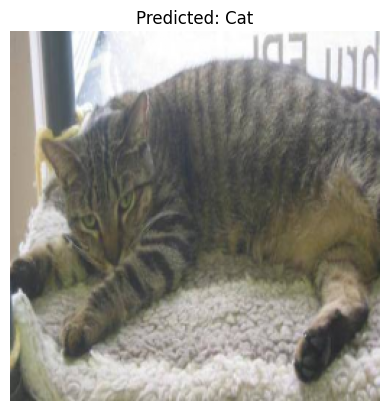

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess image
img = cv2.imread('D:/Desktop/jupyter notebook/dogs-vs-cats/test/cats/cat.10017.jpg')


img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
img = cv2.resize(img, (256, 256))          
img = img.astype('float32') / 255.0        
img_input = np.expand_dims(img, axis=0)    
# Predict
try:
    prediction = model.predict(img_input)
    predicted_class = int(prediction[0][0] > 0.5)
    # print("Prediction:", "Dog" if predicted_class else "Cat")
    print(f"Prediction: {'Dog' if predicted_class else 'Cat'} (Confidence: {prediction[0][0]:.2f})")


    # Show the image
    plt.imshow(img)
    plt.title("Predicted: " + ("Dog" if predicted_class else "Cat"))
    plt.axis('off')
    plt.show()

except Exception as e:
    print("Prediction error:", e)
